# PlotBot
### Build a Twitter bot that sends out visualized sentiment analysis of a Twitter account's recent tweets. The bot receives tweets via mentions and in turn performs sentiment analysis on the most recent twitter account specified in the mention

In [1]:
# Dependencies
import tweepy
import json
import time
import pandas as pd
import yaml
import matplotlib.pyplot as plt
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [2]:
# Twitter API Keys
TWITTER_CONFIG_FILE = "auth.yaml"
with open(TWITTER_CONFIG_FILE, 'r') as config_file:
    config = yaml.load(config_file)

consumer_key = config["twitter"]["consumer_key"]
consumer_secret = config["twitter"]["consumer_secret"]
access_token = config["twitter"]["access_token"]
access_token_secret = config["twitter"]["access_token_secret"]

# Setup Tweepy API Authentication
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, parser=tweepy.parsers.JSONParser())

In [3]:
# Set up the key word and analyzer
target_term = "@CherngYwh Analyize:"
analyzer = SentimentIntensityAnalyzer()
history_list = []

## Function 1
- ### Serch for key word and filter out the new request

In [4]:
def check_key_word():
    request_list = []
    public_tweets = api.search(target_term, count=15, result_type="recent")
    for tweet in public_tweets["statuses"]:
        target_name = tweet["entities"]["user_mentions"][1]["name"]
        request_name = "@" + tweet["user"]["name"]
        if target_name in history_list:
            continue
        else:
            history_list.append(target_name)
            request_list.append('@' + target_name)
            request_list[::-1]
    return request_list, request_name

## Function 2
- ### Analyze the sentiments of 500 tweets 

In [5]:
def sentiments_list(target_user):
    sentiments = []
    counter = 1
    for x in range(25):
        public_tweets = api.user_timeline(target_user, page=x) 
        for tweet in public_tweets:
            # Run Vader Analysis on each tweet
            compound = analyzer.polarity_scores(tweet["text"])["compound"]
            pos = analyzer.polarity_scores(tweet["text"])["pos"]
            neu = analyzer.polarity_scores(tweet["text"])["neu"]
            neg = analyzer.polarity_scores(tweet["text"])["neg"]
            tweets_ago = counter
            # Add sentiments for each tweet into an array
            sentiments.append({"Date": tweet["created_at"], 
                               "Compound": compound,
                               "Positive": pos,
                               "Negative": neu,
                               "Neutral": neg,
                               "Tweets Ago": counter})
            counter = counter + 1
    return sentiments

## Final Function
- ### Combine all fuctions together to plot the data and then update figures to Timeline on Twitter

In [6]:
def PlotBot():
    # Apply check_key_word function
    request_list, request_name = check_key_word()
    length = len(request_list)
    if length > 0:
        for target_user in request_list:
            # Apply sentiments_list function
            sentiments = sentiments_list(target_user)
            sentiments_pd = pd.DataFrame.from_dict(sentiments)
            sentiment_handle = plt.plot(sentiments_pd["Tweets Ago"],
                                        sentiments_pd["Compound"], marker="o", linewidth=0.5,
                                        alpha=0.8, c ="blue", label=request_name)
            plt.style.use('seaborn-darkgrid')
            plt.title("Sentiment Analysis of Tweets (%s)" % (time.strftime("%x")))
            plt.ylabel("Tweet Polarity")
            plt.xlabel("Tweets Ago")
            plt.legend(handles = sentiment_handle, loc = 1, title = 'Tweets', bbox_to_anchor=(1.32, 1))
            plt.savefig("analysis.png", bbox_inches='tight')
            plt.show()
            api.update_with_media("analysis.png",
                                  "New Tweet Analysis: {} (Thx {} !!)".format(target_user, request_name))

## Timer
- ### Run the function to check if there are new requests every 5 minutes

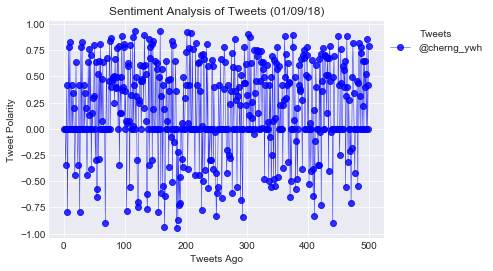

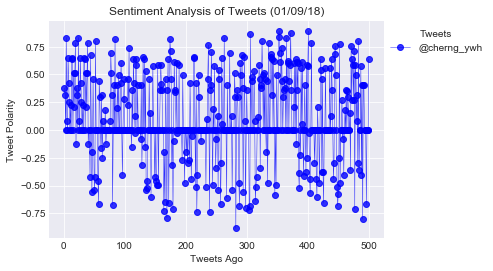

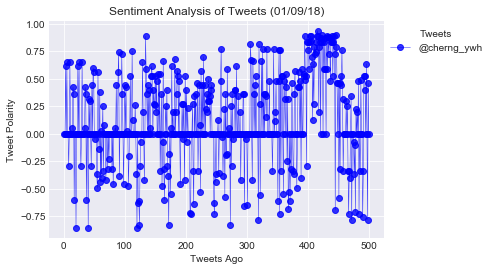

In [7]:
while True:
    PlotBot()
    time.sleep(300)